In [89]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk
import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

%matplotlib inline


TITLE_FONT = 20
LABEL_FONT = 16
TICK_FONT = 16
FIG_SIZE = (10,10)
COLORS= ["#008080","#CA562C"]

sns.set(font_scale=1.5, rc={'figure.figsize':FIG_SIZE}) 
sns.set_style("whitegrid",  {'axes.linewidth': 2, 'axes.edgecolor':'black'})
plt.rc("axes.spines", top=False, right=False)


| Feature Name | Description | 
| --- | --- |
| Target seq | target mRNA GenBank sequence accession number |
| Start | start position on target mRNA | 
| End | end position on target mRNA | 
| Sequence | siRNA sequence |
| G | nucleotide content, G |
| U | nucleotide content, U | 
| bi | stability (∆G) of dimers of siRNAs antisense strands |  
| uni | siRNA antisense strand intra-molecular structure stability (∆G) |
| duplex | ∆G of sense-antisense siRNA duplexes | 
| Pos1 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 1 | 
| Pos2 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 2 | 
| Pos6 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 6 | 
| Pos13 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 13 | 
| Pos14 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 14 | 
| Pos18 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 18 | 
| Dif_5-3 | ∆G difference between position 1 and 18 |
| Content+ | preferred dinucleotide content |
| Content- | avoided dinucleotide content | 
| Cons+ | position-dependent nucleotide consensus, preferred |
| Cons- | position-dependent nucleotide consensus, avoided |
| Cons_Sum | position-dependent nucleotide consensus, sum |
| Hyb19 | number of potential target copies in mRNAs (∆G threshold) |
| target | local target mRNA stabilities (∆G) |
| Activity | gene expression |

In [90]:
dataset = pd.read_csv("data.csv")
dataset

,Target seq,Start,End,Sequence,G,U,bi,uni,duplex,Pos1,...,Pos18,Dif_5-3,Content+,Content-,Cons+,Cons-,Cons_Sum,Hyb19,target,Activity
0,M60857,195,213,AUUAUCCACUGUUUUUGGA,3,9,-7.0,-1.9,-28.1,-1.1,...,-2.4,-1.3,2,6,2,6,4,0.001175,-8.1,24.7
1,M60857,197,215,AAAUUAUCCACUGUUUUUG,2,9,-0.7,0.0,-24.2,-0.9,...,-2.1,-1.2,1,6,1,5,4,0.001175,-8.1,9.8
2,M60857,199,217,CAAAAUUAUCCACUGUUUU,1,8,-1.5,0.0,-24.2,-2.1,...,-0.9,1.2,2,5,3,2,-1,0.001175,-11.4,50.5
3,M60857,201,219,CACAAAAUUAUCCACUGUU,1,6,-0.6,0.0,-26.7,-2.1,...,-0.9,1.2,3,3,3,3,0,0.001175,-14.5,83.7
4,M60857,203,221,GCCACAAAAUUAUCCACUG,2,4,-0.1,0.0,-30.3,-3.4,...,-2.1,1.3,4,2,2,3,1,0.001175,-17.8,60.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,M33197,717,735,GUUCAGCUCAGGGAUGACC,6,4,-9.0,-0.3,-37.8,-2.2,...,-3.3,-1.1,5,3,8,6,-2,0.000789,-15.1,26.0
649,M33197,837,855,CGCCUGCUUCACCACCUUC,2,5,-2.8,0.0,-38.6,-2.4,...,-2.4,0.0,4,4,5,3,-2,0.000789,-24.8,48.0
650,M33197,972,990,GAGCUUGACAAAGUGGUCG,7,4,-7.9,-2.3,-34.1,-2.4,...,-2.4,0.0,3,2,5,4,-1,0.000789,-5.2,36.0
651,M33197,1008,1026,GUUGCUGUAGCCAAAUUCG,5,6,-9.5,-0.3,-31.7,-2.2,...,-2.4,-0.2,3,3,2,4,2,0.000789,-11.6,25.0


In [96]:
num_dataset = get_numerical(df)
num_dataset

,Start,End,G,U,bi,uni,duplex,Pos1,Pos2,Pos6,...,Pos18,Dif_5-3,Content+,Content-,Cons+,Cons-,Cons_Sum,Hyb19,target,Activity
0,195,213,3,9,-7.0,-1.9,-28.1,-1.1,-0.9,-3.3,...,-2.4,-1.3,2,6,2,6,4,0.001175,-8.1,24.7
1,197,215,2,9,-0.7,0.0,-24.2,-0.9,-0.9,-1.1,...,-2.1,-1.2,1,6,1,5,4,0.001175,-8.1,9.8
2,199,217,1,8,-1.5,0.0,-24.2,-2.1,-0.9,-0.9,...,-0.9,1.2,2,5,3,2,-1,0.001175,-11.4,50.5
3,201,219,1,6,-0.6,0.0,-26.7,-2.1,-2.2,-0.9,...,-0.9,1.2,3,3,3,3,0,0.001175,-14.5,83.7
4,203,221,2,4,-0.1,0.0,-30.3,-3.4,-3.3,-0.9,...,-2.1,1.3,4,2,2,3,1,0.001175,-17.8,60.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,717,735,6,4,-9.0,-0.3,-37.8,-2.2,-0.9,-3.4,...,-3.3,-1.1,5,3,8,6,-2,0.000789,-15.1,26.0
649,837,855,2,5,-2.8,0.0,-38.6,-2.4,-3.4,-3.4,...,-2.4,0.0,4,4,5,3,-2,0.000789,-24.8,48.0
650,972,990,7,4,-7.9,-2.3,-34.1,-2.4,-2.1,-2.1,...,-2.4,0.0,3,2,5,4,-1,0.000789,-5.2,36.0
651,1008,1026,5,6,-9.5,-0.3,-31.7,-2.2,-0.9,-2.1,...,-2.4,-0.2,3,3,2,4,2,0.000789,-11.6,25.0


# Training Data and Test Data

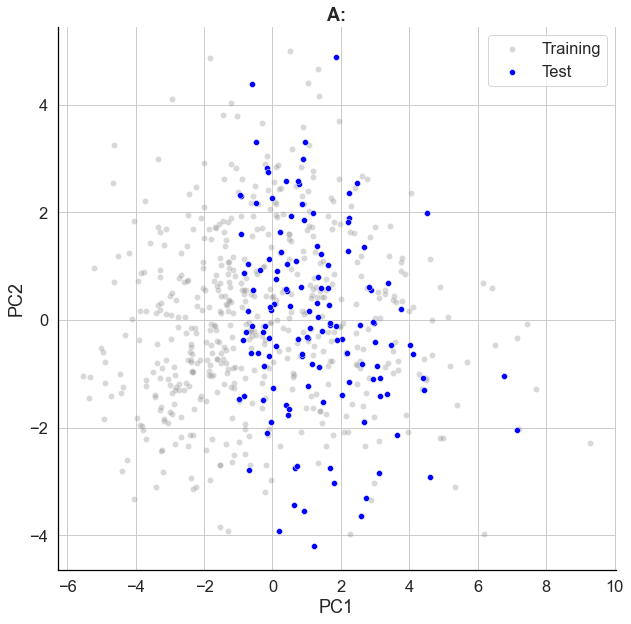

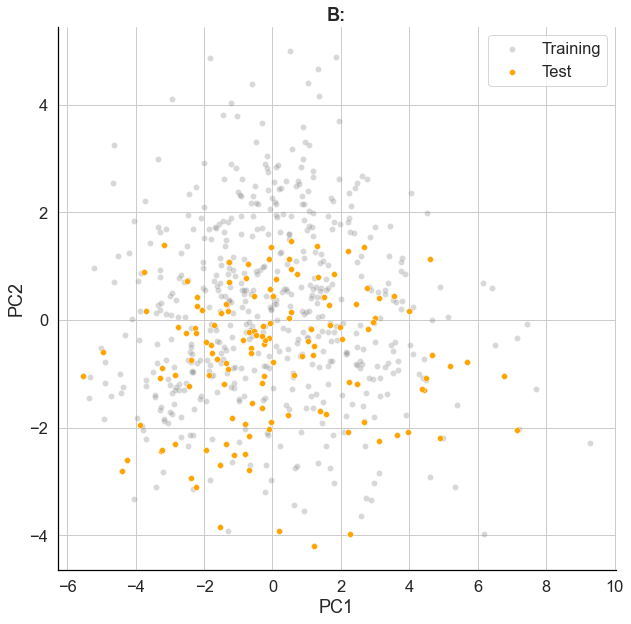

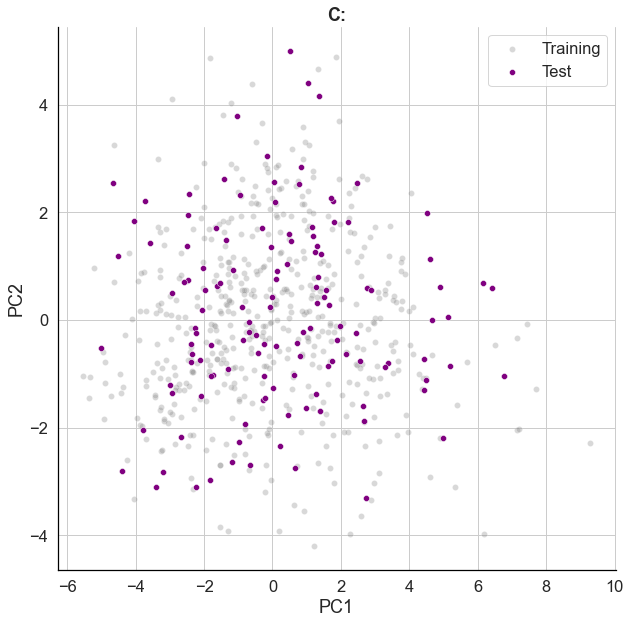

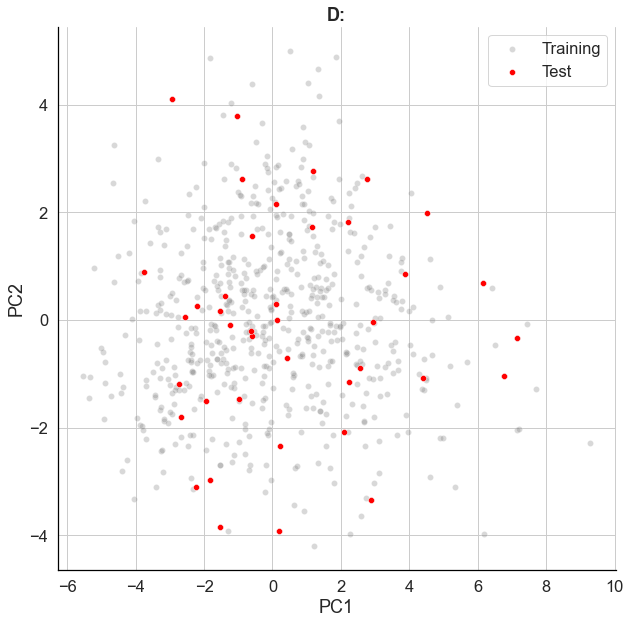

In [95]:
def get_numerical(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_df = df.select_dtypes(include=numerics)
    return num_df
    
    
def performPCA(X, n_dimensions=2):
    """
    Uses sklearn PCA tool to perform PCA
    input:
    X: Pandas Dataframe or Numpy Array of features
    n_dimensions: Number of PCs to fit
    
    output:
    X_pca: Pandas dataframe with column titles of PC1,...,PCn
    """
    X_data = get_numerical(X)
    X_standardized = StandardScaler().fit_transform(X_data)
    pca = PCA(n_components=n_dimensions)
    pca.fit(X_standardized)
    X_pca_array = pca.transform(X_standardized)
    column_names = ['PC{}'.format(i+1) for i in range(n_dimensions)] 
    X_pca = pd.DataFrame(X_pca_array, columns=column_names)
    return X_pca

def makeplots(pca_data):
    sns.scatterplot(x="PC1", y="PC2", data=pca_data, color="grey",alpha=.3, label="Training")
    biased_A = pca_data[pca_data["PC1"]>-1]
    sns.scatterplot(x="PC1", y="PC2", data=biased_A.sample(130), color="blue", label="Test")
    plt.title("A:", fontweight="bold")
    plt.show()
    sns.scatterplot(x="PC1", y="PC2", data=pca_data, color="grey",alpha=.3, label="Training")
    biased_B = pca_data[pca_data["PC2"]<1.5]
    sns.scatterplot(x="PC1", y="PC2", data=biased_B.sample(130), color="orange", label="Test")
    plt.title("B:", fontweight="bold")
    plt.show()
    sns.scatterplot(x="PC1", y="PC2", data=pca_data, color="grey",alpha=.3, label="Training")
    sns.scatterplot(x="PC1", y="PC2", data=pca_data.sample(130), color="purple", label="Test")
    plt.title("C:", fontweight="bold")
    plt.show()
    sns.scatterplot(x="PC1", y="PC2", data=pca_data, color="grey",alpha=.3, label="Training")
    sns.scatterplot(x="PC1", y="PC2", data=pca_data.sample(40), color="red", label="Test")
    plt.title("D:", fontweight="bold")
    plt.show()

pca = performPCA(dataset)
makeplots(pca)


Intercept of MLR model is -18085902845887.27
Regression Coefficients: 
Start ~ -1004772380329.30
End ~ 1004772380329.31
G ~ -0.45
U ~ 1.54
bi ~ 0.07
uni ~ -1.92
duplex ~ 0.62
Pos1 ~ 475972424.00
Pos2 ~ -1.99
Pos6 ~ -1.54
Pos13 ~ -0.76
Pos14 ~ 0.12
Pos18 ~ -475972424.35
Dif_5-3 ~ 475972429.56
Content+ ~ 1.96
Content- ~ -0.79
Cons+ ~ -206686539.11
Cons- ~ 206686538.59
Cons_Sum ~ -206686543.25
Hyb19 ~ -9476.96
target ~ -0.43


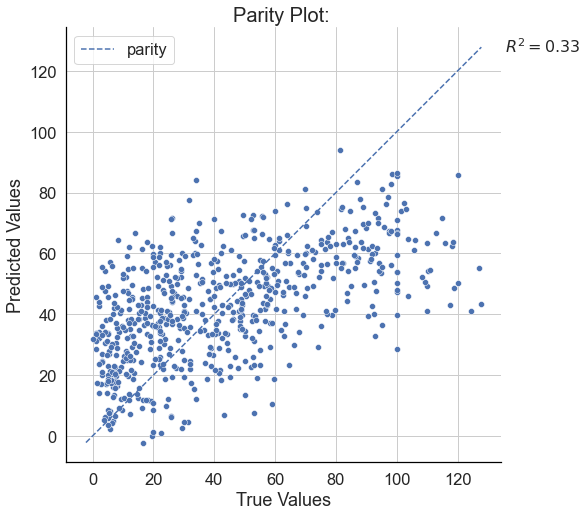

interactive(children=(Checkbox(value=True, description='Start'), Checkbox(value=True, description='End'), Chec…

In [116]:
def linear_regression(df, feature_cols, response_col, standardized = False):
    """
    Use linear_model to run a linear regression using sklearn
    
    """
    X = df[feature_cols]
    y = df[response_col]
    if standardized:
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.values.reshape(-1, 1))
    regression = linear_model.LinearRegression() 
    regression.fit(X,y)
    
    try:
        print('Intercept of MLR model is {0:0.2f}'.format(regression.intercept_))
    except TypeError:
        print('Intercept of MLR model is {0:0.2f}'.format(regression.intercept_[0]))
    print('Regression Coefficients: ')
    for feature, coef in zip(feature_cols, regression.coef_.flatten()):
        print(f'{feature} ~ {coef:.2f}')
    return regression.predict(X), regression.score(X,y)

def parity_plot(true, pred, r_squared=None, title='', hue=None):
    """
    plot true vs the predicted data
    inputs: 2 list-like (arrays) data structures
    """
    fig, ax = plt.subplots(1,1,figsize=(10, 8))
    if hue is not None:
        sns.scatterplot(x=true, y=pred, hue=hue)
    else: 
        sns.scatterplot(x=true, y=pred)
    min_value = min(min(true), min(pred))
    max_value = max(max(true), max(pred))
    plt.plot([min_value, max_value],[min_value, max_value], '--', label="parity")
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    ax.set_box_aspect(1)
    sns.despine()
    plt.text(1.01, 0.98, r"$R^2 = {0:.2f}$".format(r_squared),
         ha='left', va='top', size =LABEL_FONT,
         transform=ax.transAxes)
    plt.title('Parity Plot: {}'.format(title), size=TITLE_FONT)
    plt.legend(loc='best')
    plt.show()    
    
def run_regression(data, 
                   feature_cols = ['Start', 
                                   'End', 
                                   'G', 
                                   'U', 
                                   'bi', 
                                   'uni', 
                                   'duplex', 
                                   'Pos1', 
                                   'Pos2', 
                                   'Pos6', 
                                   'Pos13', 
                                   'Pos14', 
                                   'Pos18', 
                                   'Dif_5-3', 
                                   'Content+', 
                                   'Content-', 
                                   'Cons+', 
                                   'Cons-', 
                                   'Cons_Sum', 
                                   'Hyb19', 
                                   'target'
                                  ], 
                     response_col='Activity',
                     standardized=False,
                     parity=True,
                     ):
    y_pred, r_squared = linear_regression(data, feature_cols, response_col, standardized = standardized)
    if parity: parity_plot(data[response_col], y_pred.flatten(), r_squared)

run_regression(data=num_dataset)



In [117]:
@widgets.interact()   
def regression_wrapper(Start = True,
                       End = True,
                       G = True,
                       U = True,
                       bi = True,
                       uni = True,
                       duplex = True,
                       Pos1 = True,
                       Pos2 = True,
                       Pos6 = True,
                       Pos13 = True,
                       Pos14 = True,
                       Pos18 = True,
                       Dif_5_3 = True,
                       Content_plus = True,
                       Content_minus = True,
                       Cons_plus = True,
                       Cons_minus = True,
                       Cons_Sum = True,
                       Hyb19 = True,
                       target = True):
    response="Activity"
    features = []
    if Start: features.append('Start')
    if End: features.append('End')
    if G: features.append('G')
    if U: features.append('U')
    if bi: features.append('bi')
    if uni: features.append('uni')
    if duplex: features.append('duplex')
    if Pos1: features.append('Pos1')
    if Pos2: features.append('Pos2')
    if Pos6: features.append('Pos6')
    if Pos13: features.append('Pos13')
    if Pos14: features.append('Pos14')
    if Pos18: features.append('Pos18')
    if Dif_5_3: features.append('Dif_5-3')
    if Content_plus: features.append('Content+')
    if Content_minus: features.append('Content-')
    if Cons_plus: features.append('Cons+')
    if Cons_minus: features.append('Cons-')
    if Cons_Sum: features.append('Cons_Sum')
    if Hyb19: features.append('Hyb19')
    if target: features.append('target')        

    run_regression(data=num_dataset, feature_cols=features, response_col = response)
    
def cross_validation():
    scores = cross_validate(lasso, X, y, cv=10,
                            scoring=('r2', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    print(scores['test_neg_roo_mean_squared_error'])
    print(scores['train_r2'])
def test():

interactive(children=(Checkbox(value=True, description='Start'), Checkbox(value=True, description='End'), Chec…

This model is not very good. What stands out? 

Let's try a different approach.

In [108]:
print(num_dataset.columns.to_list())

print("features = []")
for feature in num_dataset.columns.to_list():
    print(f"{feature} = True,")

['Start', 'End', 'G', 'U', 'bi', 'uni', 'duplex', 'Pos1', 'Pos2', 'Pos6', 'Pos13', 'Pos14', 'Pos18', 'Dif_5-3', 'Content+', 'Content-', 'Cons+', 'Cons-', 'Cons_Sum', 'Hyb19', 'target', 'Activity']
features = []
Start = True,
End = True,
G = True,
U = True,
bi = True,
uni = True,
duplex = True,
Pos1 = True,
Pos2 = True,
Pos6 = True,
Pos13 = True,
Pos14 = True,
Pos18 = True,
Dif_5-3 = True,
Content+ = True,
Content- = True,
Cons+ = True,
Cons- = True,
Cons_Sum = True,
Hyb19 = True,
target = True,
Activity = True,
